- - -
- - -
# 1. Object proposal

## 1.1. Visualize the dataset
> Familiarise yourself with the data and visualize some examples with the ground-truth bounding boxes.

In [ ]:
IMG_SIZE = 256

In [3]:
def map_value(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

In [4]:
import xml.etree.ElementTree as ET

def get_bounding_boxes(folder):
    tree = ET.parse(f"./Potholes/annotated-images/{folder}/data.xml")
    root = tree.getroot()
    
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)

    bbox_coordinates = []
    for member in root.findall('object'):
        class_name = member[0].text
        xmin = int(map_value(int(member[4][0].text), 0, width, 0, IMG_SIZE))
        ymin = int(map_value(int(member[4][1].text), 0, height, 0, IMG_SIZE))
        xmax = int(map_value(int(member[4][2].text), 0, width, 0, IMG_SIZE))
        ymax = int(map_value(int(member[4][3].text), 0, height, 0, IMG_SIZE))
        bbox_coordinates.append([class_name, xmin, ymin, xmax, ymax])
        
    return bbox_coordinates

In [5]:
import cv2

def get_image_with_boxes(folder):
    # Read image
    img = cv2.imread(f"./Potholes/annotated-images/{folder}/original.jpg")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Create a copy of the image to draw on
    img_with_boxes = img.copy()
    
    bbox_coordinates = get_bounding_boxes(folder)
    
    # Add bounding boxes and labels
    for bbox in bbox_coordinates:
        class_name, xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
        cv2.putText(img_with_boxes, class_name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    return img_with_boxes

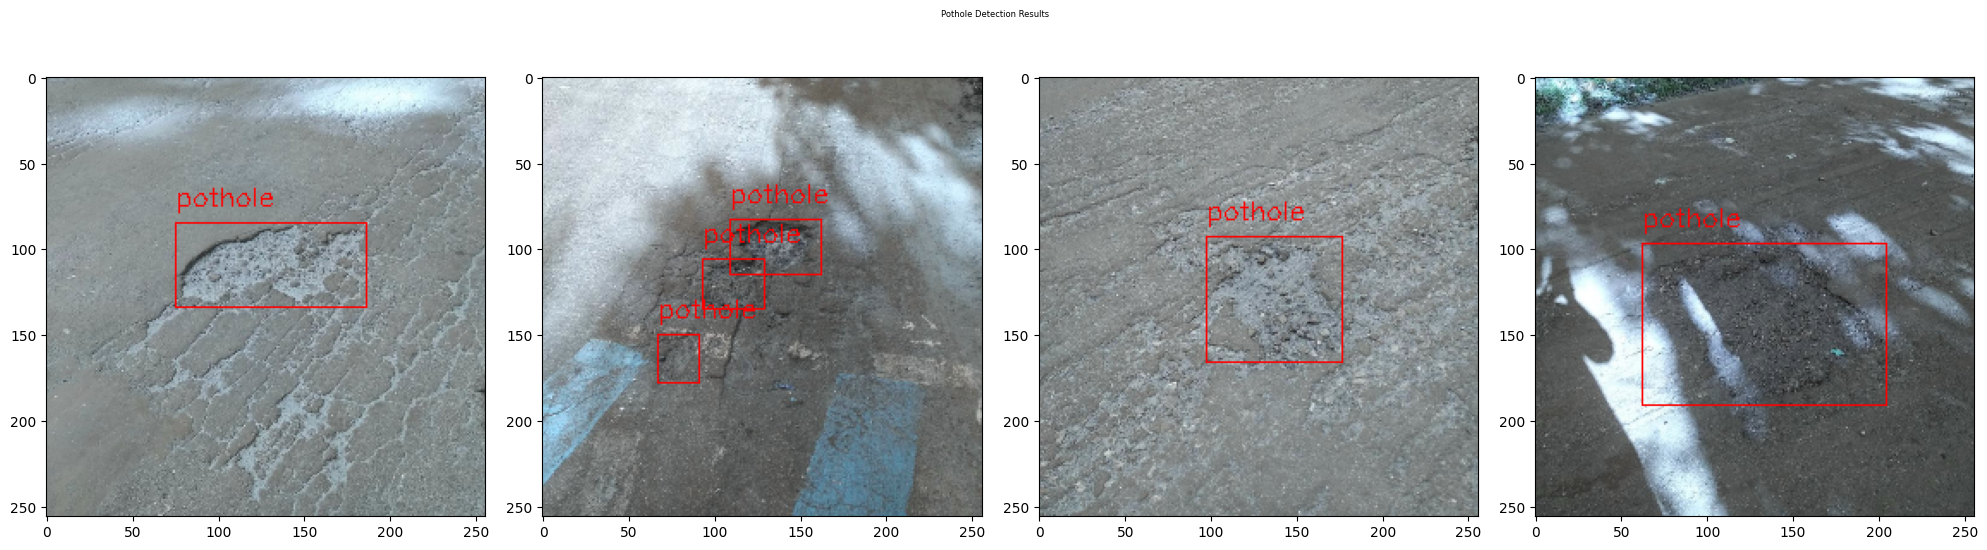

In [6]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Pothole Detection Results', fontsize=6, y=1.05)

# Plot first three images
for i, ax in enumerate(axes, 1):
    image_with_boxes = get_image_with_boxes(f'img-{i}')
    ax.imshow(image_with_boxes)

plt.tight_layout()
plt.show()

- - -
## 1.2. Calculate object proposals
> Extract object proposals for all the images of the dataset (e.g. Selecting Search, Edge Boxes, etc). 
> 
> ``` admonition
> Note that you may have to resize the images before you run SS for better efficiency. 
> ```

We can exploit the built-in function selective_search from the cv2 library to get the proposals:

In [ ]:
import selectivesearch

def selective_search_algorithm(image):
    # Perform selective search
    _, regions = selectivesearch.selective_search(
        image,
        scale=50,     # Higher means larger clusters in hierarchical grouping
        sigma=0.9,     # Width of Gaussian kernel for felzenszwalb
        min_size=10    # Minimum component size for felzenszwalb
    )
    
    # Create list to store the candidate rects
    proposals = []
    for r in regions:
        # skip duplicates
        if r['rect'] in proposals:
            continue
        
        # skip small proposals
        # if r['size'] < 20:
        #     continue
            
        # Extract bounding box coordinates
        x, y, w, h = r['rect']
        
        # skip proposals with zero area
        if h == 0 or w == 0:
            continue
        
        # skip proposals with aspect ratio > 2
        if w / h > 3 or h / w > 3:
            continue
        
        proposals.append((x, y, x + w, y + h))
    
    return proposals

Here a helper function to show:
- the original image
- the correct bounding boxes
- the proposals of the selective search algorithm

In [ ]:
def plot_proposals(folder):
    path = f"./Potholes/annotated-images/{folder}/original.jpg"
    
    # Read image and resize it
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    # Image with labels
    image_with_boxes = get_image_with_boxes(folder)
    # image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    ax[1].imshow(image_with_boxes)
    ax[1].set_title('Correct Labels') 
    ax[1].axis('off')
    
    # Image with proposals
    ax[2].imshow(img)
    # Get region proposals using OpenCV
    rects = selective_search_algorithm(img)
    # Plot first max_proposals boxes
    for x, y, w, h in rects:
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax[2].add_patch(rect)
    ax[2].set_title(f'Region Proposals')
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return rects

Let's see the results of the algorithm for the first three images in the dataset.

c:\Users\longo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


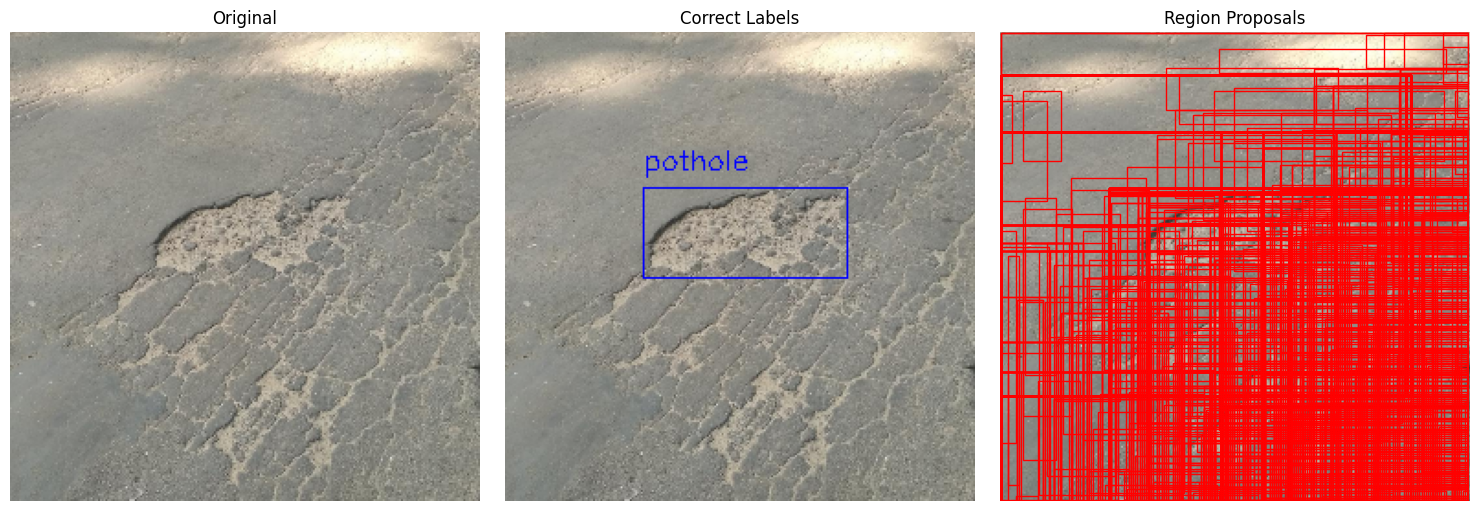

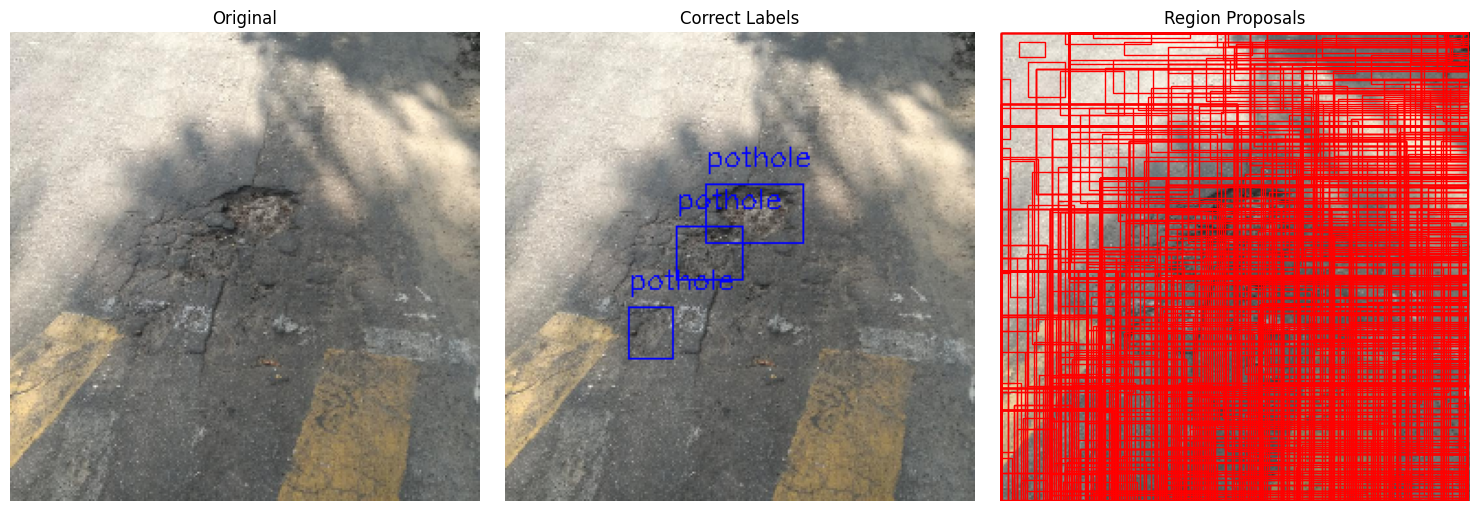

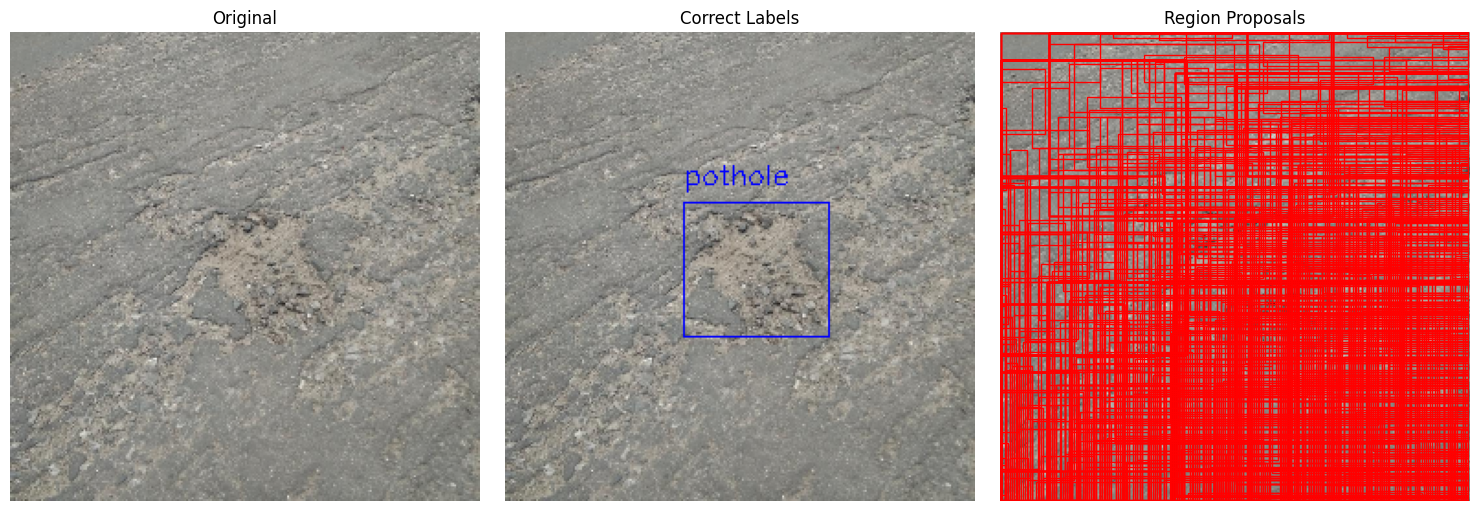

In [9]:
for idx in range(1, 4):
    plot_proposals(f'img-{idx}')

For every image in the dataset, we can run the selective-search algorithm and store the proposals in a json file:

In [30]:
import os
import json

for folder in os.listdir("./Potholes/annotated-images"):
    img = cv2.imread(os.path.join("./Potholes/annotated-images", folder, "original.jpg"))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    rects = selective_search_algorithm(img)
    
    # Create a list of bounding box data in the desired format
    bbox_data = []
    for rect in rects:
        bbox_data.append({
            "class": "",
            "xmin": rect[0],
            "ymin": rect[1],
            "xmax": rect[2],
            "ymax": rect[3]
        })
    
    # Save the bounding box data to a JSON file
    with open(os.path.join("./Potholes/annotated-images", folder, "data.json"), "w") as f:
        json.dump(bbox_data, f, indent=4)

c:\Users\longo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


## 1.3. Proposals evaluation
> Evaluate the extracted proposals on the training set of the dataset and determine the number of required proposals

Now we can use the Intersection over Union (IoU) metric to evaulate the generated proposals and see how well the match the ground truth. 

In [31]:
import json

def get_image_with_classified_proposals(folder):
    img = cv2.imread(f"./Potholes/annotated-images/{folder}/original.jpg")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create a copy of the image to draw on
    img_with_evaluated_boxes = img.copy()
    
    rects = json.load(open(f"Potholes/annotated-images/{folder}/data.json"))
    for rect in rects:
        xmin, ymin, xmax, ymax = rect['xmin'], rect['ymin'], rect['xmax'], rect['ymax']
        if rect['class'] == 'pothole':
            cv2.rectangle(img_with_evaluated_boxes, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
            cv2.putText(img_with_evaluated_boxes, f'IoU: {rect["iou"]:.2f}', (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
   
    return img_with_evaluated_boxes

## 1.4. Proposal labeling
> Prepare the proposals for the training of the object detector. This requires assigning a label (i.e., class or background label) to each proposal.

In [32]:
def intersection_over_union(box1, box2):
    (x1_min, y1_min, x1_max, y1_max) = box1
    (x2_min, y2_min, x2_max, y2_max) = box2

    # Compute intersection
    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    intersection = max(0, x_right - x_left) * max(0, y_bottom - y_top)

    # Compute union
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    union = float(box1_area + box2_area - intersection)

    return intersection / union

In [33]:
import json
import os

k_1 = 0.5
k_2 = 0.5

for folder in os.listdir("./Potholes/annotated-images"):
    ground_truth = get_bounding_boxes(folder)
    proposals = json.load(open(f"./Potholes/annotated-images/{folder}/data.json"))
    for proposal in proposals:
        xmin, ymin, xmax, ymax = proposal["xmin"], proposal["ymin"], proposal["xmax"], proposal["ymax"]
        
        max_iou = 0.0
        for _, gt_xmin, gt_ymin, gt_xmax, gt_ymax in ground_truth:
            iou = intersection_over_union([xmin, ymin, xmax, ymax], [gt_xmin, gt_ymin, gt_xmax, gt_ymax])
            max_iou = max(max_iou, iou)
                
        if max_iou < k_1:
            proposal["class"] = "background"
        elif max_iou > k_2:
            proposal["class"] = "pothole"
            proposal["iou"] = max_iou
        else:
            proposal["class"] = "not identified"
                
    with open(os.path.join("./Potholes/annotated-images", folder, "data.json"), "w") as f:
        json.dump(proposals, f, indent=4)

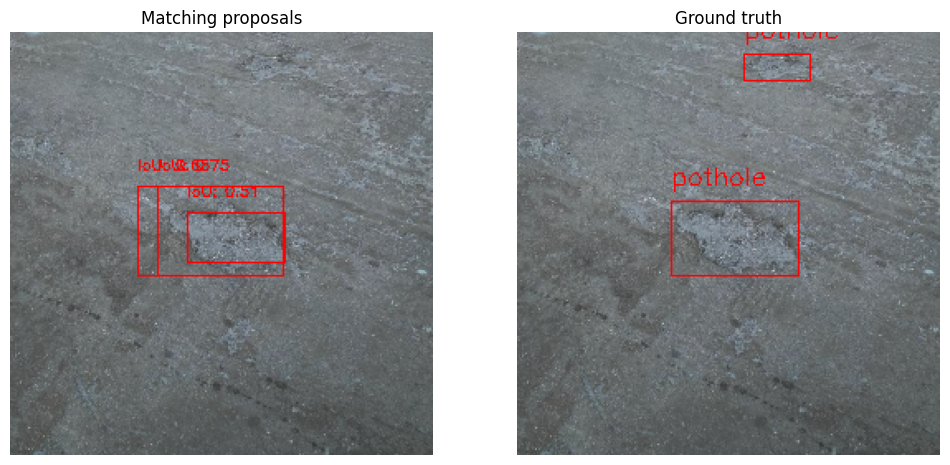

In [41]:
folder = 'img-9'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img_with_proposals = get_image_with_classified_proposals(folder) 
ax[0].imshow(img_with_proposals)
ax[0].title.set_text('Matching proposals')
ax[0].axis('off')

img_with_boxes = get_image_with_boxes(folder)
ax[1].imshow(img_with_boxes)
ax[1].title.set_text('Ground truth')
ax[1].axis('off')

plt.show()

- - -
# 2. Object Detection

## 2.1. Classifier model
> Build a convolutional neural network to classify object proposals ($N+1$ classes)

First we can import the VGG16 pre-trained model and modify the last layer so that it only has two outputs, one for the 'pothole' class and one for the 'background' class.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

def setup_model(freeze_features=True):
    model = models.vgg16(pretrained=True)
    
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False
    
    model.classifier[6] = nn.Linear(4096, 2)
    
    return model

In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        
        print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')
            
    return model

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Define transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    # Load datasets
    # Replace 'data_dir' with your dataset directory
    data_dir = 'path/to/your/data'
    train_dataset = datasets.ImageFolder(data_dir + '/train', data_transforms['train'])
    val_dataset = datasets.ImageFolder(data_dir + '/val', data_transforms['val'])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    
    # Setup model
    num_classes = len(train_dataset.classes)
    model = setup_model(num_classes)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Train model
    model = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=10,
        device=device
    )

if __name__ == '__main__':
    main()

## 2.2. Data loader
Build a dataloader for the object detection task. 

```admonition
Think about the class imbalance issue of the background proposals
```

## 2.3. Fine-tuning
Finetune the network on the training set.

## 2.4. Evaluation
Evaluate the classification accuracy of the network on the validation set.

```admonition
Note that this is different from the evaluation of the object detection task.
```

- - -